# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score 

In [2]:
data = pd. read_csv("https://code.s3.yandex.net/datasets/Churn.csv")
display(data.head())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
print("Размер таблицы: ", data.shape)
print("Количество дубликатов:", data.duplicated().sum())
print(data.info())
print(data.describe)
print(data.isnull().sum())
#data.columns = data.columns.str.lower()

Размер таблицы:  (10000, 14)
Количество дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None
<bound method NDFrame.describe of       RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             1    15634602   Hargrave          619    France  Female   42   
1            

In [4]:
print(data['CustomerId'].value_counts())
#раз каждая строка - уникальный клиента, удалим часть столбцов
data_new = data.drop(['RowNumber',  'CustomerId', 'Surname'], axis=1)

15812607    1
15741078    1
15635776    1
15740223    1
15738174    1
           ..
15743714    1
15639265    1
15641312    1
15684319    1
15695872    1
Name: CustomerId, Length: 10000, dtype: int64


In [5]:
display(data_new.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


                 CreditScore       Age    Tenure   Balance  NumOfProducts  \
CreditScore         1.000000 -0.003965 -0.000062  0.006268       0.012238   
Age                -0.003965  1.000000 -0.013134  0.028308      -0.030680   
Tenure             -0.000062 -0.013134  1.000000 -0.007911       0.011979   
Balance             0.006268  0.028308 -0.007911  1.000000      -0.304180   
NumOfProducts       0.012238 -0.030680  0.011979 -0.304180       1.000000   
HasCrCard          -0.005458 -0.011721  0.027232 -0.014858       0.003183   
IsActiveMember      0.025651  0.085472 -0.032178 -0.010084       0.009612   
EstimatedSalary    -0.001384 -0.007201  0.010520  0.012797       0.014204   
Exited             -0.027094  0.285323 -0.016761  0.118533      -0.047820   

                 HasCrCard  IsActiveMember  EstimatedSalary    Exited  
CreditScore      -0.005458        0.025651        -0.001384 -0.027094  
Age              -0.011721        0.085472        -0.007201  0.285323  
Tenure       

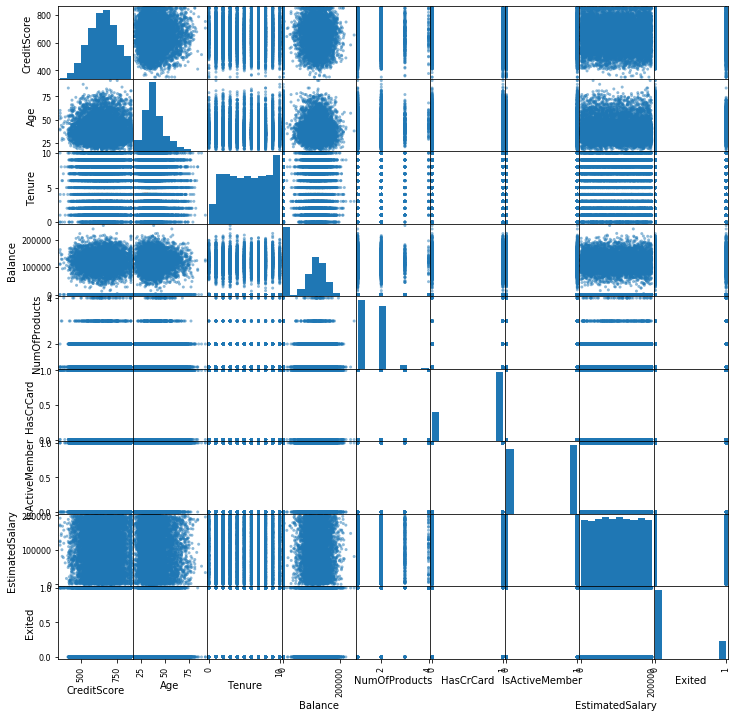

In [6]:
# заполним пропуски в колонке Tenure, предварительно проверив зависимость
print(data_new.corr())
pd.plotting.scatter_matrix(data_new, figsize = (12,12))
plt.show()

In [7]:
#зависимости от других величин нет, заполню "-1"б чтобы не пересекалось с другими значениями
data_new['Tenure'] = data_new['Tenure'].fillna(-1)

In [8]:
# Техникой OHE переведем категориальные признаки в численные
data_ohe = pd.get_dummies(data_new, drop_first=True)
target = data_ohe['Exited']
features = data_ohe.drop(['Exited'], axis = 1)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.4, random_state=123)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size = 0.5, random_state=123)

# стандартизируем данные
numeric = ['Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric]) 
features_test[numeric] = scaler.transform(features_test[numeric]) 

### Вывод:
Я загрузила таблицу с данными о клиентах банка. Датасет состоит из 10000 строк и 14 колонок. Дублей нет, типы колонок корректны. Часть данных пропущена в колонке Tenure — количество недвижимости у клиента. Т.к. анализ показал, что нет корреляции между колонкой Tenure и другими колонками, то пропущенный значения я заполнила отрицательным значением "-1", чтобы они не пересекались с количествои недвижимости у других клиентов. Я удалила колонки 'RowNumber',  'CustomerId', 'Surname', т.к. это уникальные значения клиентов и эти данные не требуются для обучения моделей; техникой OHE я перевела категориальные признаки в численные и стандартизировала численные данные.
Так как у нас нет отдельной тестовой выборки, разбила исходные данные на три группы по правилу 3:1:1. Обучающая выборка - 60%, валидационная выборка - 20%, тестовая выборка - 20%. Все данные в выборках я разделина на признаки (features) и целевой признак 'Exited' (target).

# 2. Исследование задачи

In [9]:
# Исследуем баланс классов, обучим разные модели без учёта дисбаланса
model = DecisionTreeClassifier(random_state = 123)
model.fit(features_train, target_train)
print("accuracy модели DecisionTreeClassifier: ", model.score(features_valid, target_valid))
predicted_valid = model.predict(features_valid)
print("recall модели DecisionTreeClassifier: ", recall_score(target_valid, predicted_valid))
print("precision модели DecisionTreeClassifier: ", precision_score(target_valid, predicted_valid))
print("f1 модели DecisionTreeClassifier: ", f1_score(target_valid, predicted_valid))
print()

n_estimatots = 0
max_depth = 0
best_f1 = 0
for i in range(1,15):
    for j in range(1,101,10):
        model = RandomForestClassifier(random_state = 123, max_depth=i, n_estimators = j)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        if best_f1<f1:
            best_f1 = f1
            max_depth = i
            n_estimators = j

model = RandomForestClassifier(n_estimators=n_estimators, max_depth = max_depth, random_state = 123)
model.fit(features_train, target_train)
print("Лучшая глубина:", max_depth, "   |   Лучшее кол-во деревьев:", n_estimators)
print("accuracy модели RandomForestClassifier: ", model.score(features_valid, target_valid))
predicted_valid = model.predict(features_valid)
print("recall модели RandomForestClassifier: ", recall_score(target_valid, predicted_valid))
print("precision модели RandomForestClassifier: ", precision_score(target_valid, predicted_valid))
print("f1 модели RandomForestClassifier: ", f1_score(target_valid, predicted_valid))
print()

model = LogisticRegression(solver='liblinear', random_state = 123)
model.fit(features_train, target_train)
print("accuracy модели LogisticRegression: ", model.score(features_valid, target_valid))
predicted_valid = model.predict(features_valid)
print("recall модели LogisticRegression: ", recall_score(target_valid, predicted_valid))
print("precision модели LogisticRegression: ", precision_score(target_valid, predicted_valid))
print("f1 модели LogisticRegression: ", f1_score(target_valid, predicted_valid))
print()

# проверка модели на адекватность
dummy_model = DummyClassifier(strategy = 'most_frequent', random_state = 123)
dummy_model.fit(features_train, target_train)
print("accuracy модели DummyClassifier: ", dummy_model.score(features_valid, target_valid))
predicted_valid = dummy_model.predict(features_valid)
print("recall модели DummyClassifier: ", recall_score(target_valid, predicted_valid))
print("precision модели DummyClassifier: ", precision_score(target_valid, predicted_valid))
print("f1 модели DummyClassifier: ", f1_score(target_valid, predicted_valid))

accuracy модели DecisionTreeClassifier:  0.7965
recall модели DecisionTreeClassifier:  0.5329949238578681
precision модели DecisionTreeClassifier:  0.48498845265588914
f1 модели DecisionTreeClassifier:  0.5078597339782346

Лучшая глубина: 14    |   Лучшее кол-во деревьев: 21
accuracy модели RandomForestClassifier:  0.8685
recall модели RandomForestClassifier:  0.4720812182741117
precision модели RandomForestClassifier:  0.7717842323651453
f1 модели RandomForestClassifier:  0.5858267716535432

accuracy модели LogisticRegression:  0.813
recall модели LogisticRegression:  0.19289340101522842
precision модели LogisticRegression:  0.5757575757575758
f1 модели LogisticRegression:  0.2889733840304182

accuracy модели DummyClassifier:  0.813
recall модели DummyClassifier:  0.19289340101522842
precision модели DummyClassifier:  0.5757575757575758
f1 модели DummyClassifier:  0.2889733840304182


### Вывод:
Предворительно я обучила разные модели без учёта дисбаланса классов и проверила модели на адекватность.
Результаты по моделям:

DecisionTreeClassifier:
accuracy:  0.796
recall:  0.53
precision:  0.48
f1:  0.5

RandomForestClassifier:
accuracy:  0.8685
recall:  0.47
precision:  0.77
f1:  0.58

LogisticRegression:
accuracy:  0.813
recall:  0.19
precision:  0.57
f1:  0.28

DummyClassifier:
accuracy:  0.813
recall:  0.19
precision:  0.57
f1:  0.28

Стоит отметить, что метрики модели логистической регрессии такие же как и метрики "глупой" модели, где целевой признак заполняется наиболее часто встречающимся классом. Наилучшие результаты показала модель случайного леса с глубиной 14 и кол-вов деревьев 21 - f1-метрика равна 0.58.

# 3. Борьба с дисбалансом

In [10]:
print("Размер целевого признака с классом 0:", data.query("Exited==0").shape)
print("Размер целевого признака с классом 1:", data.query("Exited==1").shape)
repeat = round(data.query("Exited==0").shape[0] / data.query("Exited==1").shape[0])
print("Repeat =", repeat)

Размер целевого признака с классом 0: (7963, 14)
Размер целевого признака с классом 1: (2037, 14)
Repeat = 4


In [11]:
# обучение логистической регрессии со сбалансированными классами
model = LogisticRegression(random_state=123, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("f1 модели LogisticRegression со сбалансированным классом:", f1_score(target_valid, predicted_valid))

f1 модели LogisticRegression со сбалансированным классом: 0.45789473684210535


In [12]:
# применим метод upsampling (увеличим выборку)
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)

model = LogisticRegression(random_state=123, solver = 'liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("f1 модели LogisticRegression при увеличении выборки:", f1_score(target_valid, predicted_valid))

model = DecisionTreeClassifier(random_state=123)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("f1 модели DecisionTreeClassifier при увеличении выборки:", f1_score(target_valid, predicted_valid))

model = RandomForestClassifier(random_state=123, n_estimators = n_estimators, max_depth=max_depth)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("f1 модели RandomForestClassifier при увеличении выборки:", f1_score(target_valid, predicted_valid))


f1 модели LogisticRegression при увеличении выборки: 0.4621993127147766
f1 модели DecisionTreeClassifier при увеличении выборки: 0.5075757575757576
f1 модели RandomForestClassifier при увеличении выборки: 0.6015424164524421


In [13]:
# измененим порог
# LogisticRegression
best_f1 = 0
best_threshold = 0
model = LogisticRegression(random_state=123, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    if best_f1<f1:
        best_f1 = f1
        best_threshold = threshold
print("Лучший показатель f1 модели LogisticRegression - {}, при пороге {}".format(best_f1, best_threshold))
print("auc_roc = ", roc_auc_score(target_valid, probabilities_one_valid))

# DecisionTreeClassifier
best_f1 = 0
best_threshold = 0
model = DecisionTreeClassifier(random_state=123)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    if best_f1<f1:
        best_f1 = f1
        best_threshold = threshold
        
print("Лучший показатель f1 модели DecisionTreeClassifier - {}, при пороге {}".format(best_f1, best_threshold))
print("auc_roc = ", roc_auc_score(target_valid, probabilities_one_valid))


# RandomForestClassifier
best_f1 = 0
best_threshold = 0
model = RandomForestClassifier(random_state=123, n_estimators = n_estimators, max_depth=max_depth)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    if best_f1<f1:
        best_f1 = f1
        best_threshold = threshold
print("Лучший показатель f1 модели RandomForestClassifier - {}, при пороге {}".format(best_f1, best_threshold))
print("auc_roc = ", roc_auc_score(target_valid, probabilities_one_valid))

Лучший показатель f1 модели LogisticRegression - 0.4737945492662474, при пороге 0.26
auc_roc =  0.7465326725287785
Лучший показатель f1 модели DecisionTreeClassifier - 0.5078597339782346, при пороге 0.0
auc_roc =  0.6970703137346624
Лучший показатель f1 модели RandomForestClassifier - 0.6234482758620691, при пороге 0.4
auc_roc =  0.8520894045805387


### Вывод:
Размер целевого признака с классом 0: (7963, 14), размер целевого признака с классом 1: (2037, 14), значит класс "1" практически в 4 раза меньше класса "0". У нас явный дисбаланс классов. Чтобы увеличить качество модели при дисбалансе классов, используем:
1) параметр class_weight='balanced', т.е. придаем объектам редкого класса больший вес для модели логистической регрессии. В результате  f1-метрика модели улучшилась примерно в полтора раза: 0.457.
2) метод upsampling, т.е. увеличим выборку, добавив дубликаты меньшего класса. f1 моделей увеличилось: для LogisticRegression с 0.28 до 0.46 (практически также как и при параметре class_weight='balanced', даже чуть лучше); для RandomForestClassifier с 0.58 до 0.6. А вот результтаты модели DecisionTreeClassifier практически не изменились 0.50.
3) изменение порога. Лучший показатель f1 модели LogisticRegression - 0.4737945492662474, при пороге 0.26, auc_roc =  0.7465; лучший показатель f1 модели DecisionTreeClassifier - 0.5078597339782346, при пороге 0.0, auc_roc =  0.697; лучший показатель f1 модели RandomForestClassifier - 0.6234482758620691, при пороге 0.4б auc_roc =  0.852
Итого, для модели LogisticRegression и RandomForestClassifier наилучший результат показал метод изменение порога. А вот для модели DecisionTreeClassifier используемые методы не принесли результатов. 

# 4. Тестирование модели

In [14]:
#проверим изменение порога на тестовых данных
model = RandomForestClassifier(random_state=123, n_estimators = n_estimators, max_depth=max_depth)
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

predicted_test = probabilities_one_test > best_threshold
f1 = f1_score(target_test, predicted_test)
print("Для тестовых данных:")
print("f1 =", f1)
print("auc_roc = ", roc_auc_score(target_test, probabilities_one_test))

Для тестовых данных:
f1 = 0.6098535286284953
auc_roc =  0.8461624357924514


### Вывод:
Т.к. во время анализа наилучший результат показала модель случайного леса с глубиной 14, кол-вов деревьев 21 и изменением порога 0.4, то её мы и используем для проверки на тестовых данных. Модель RandomForestClassifier дала следующие результаты: f1 = 0.6098535286284953 и auc_roc =  0.8461624357924514.

# 5. Итоговый вывод

Я загрузила таблицу с данными о клиентах банка. Датасет состоит из 10000 строк и 14 колонок. Дублей нет, типы колонок корректны. Часть данных пропущена в колонке Tenure — количество недвижимости у клиента. Т.к. анализ показал, что нет корреляции между колонкой Tenure и другими колонками, то пропущенные значения я заполнила отрицательным значением "-1", чтобы они не пересекались с количествои недвижимости у других клиентов. Я удалила колонки 'RowNumber',  'CustomerId', 'Surname', т.к. это уникальные значения клиентов и эти данные не требуются для обучения моделей; техникой OHE я перевела категориальные признаки в численные и стандартизировала численные данные.
Так как у нас нет отдельной тестовой выборки, разбила исходные данные на три группы по правилу 3:1:1. Обучающая выборка - 60%, валидационная выборка - 20%, тестовая выборка - 20%. Все данные в выборках я разделина на признаки (features) и целевой признак 'Exited' (target).

Предворительно я обучила разные модели без учёта дисбаланса классов и проверила модели на адекватность.
Результаты по моделям:

DecisionTreeClassifier:
accuracy:  0.796
recall:  0.53
precision:  0.48
f1:  0.5

RandomForestClassifier:
accuracy:  0.8685
recall:  0.47
precision:  0.77
f1:  0.58

LogisticRegression:
accuracy:  0.813
recall:  0.19
precision:  0.57
f1:  0.28

DummyClassifier:
accuracy:  0.813
recall:  0.19
precision:  0.57
f1:  0.28

Стоит отметить, что метрики модели логистической регрессии такие же как и метрики "глупой" модели, где целевой признак заполняется наиболее часто встречающимся классом. Наилучшие результаты показала модель случайного леса с глубиной 14 и кол-вов деревьев 21 - f1-метрика равна 0.58.

Размер целевого признака с классом 0: (7963, 14), размер целевого признака с классом 1: (2037, 14), значит класс "1" практически в 4 раза меньше класса "0". У нас явный дисбаланс классов. Чтобы увеличить качество модели при дисбалансе классов, используем:
1) параметр class_weight='balanced', т.е. придаем объектам редкого класса больший вес для модели логистической регрессии. В результате  f1-метрика модели улучшилась примерно в полтора раза: 0.457.
2) метод upsampling, т.е. увеличим выборку, добавив дубликаты меньшего класса. f1 моделей увеличилось: для LogisticRegression с 0.28 до 0.46 (практически также как и при параметре class_weight='balanced', даже чуть лучше); для RandomForestClassifier с 0.58 до 0.6. А вот результтаты модели DecisionTreeClassifier практически не изменились 0.50.
3) изменение порога. Лучший показатель f1 модели LogisticRegression - 0.4737945492662474, при пороге 0.26, auc_roc =  0.7465; лучший показатель f1 модели DecisionTreeClassifier - 0.5078597339782346, при пороге 0.0, auc_roc =  0.697; лучший показатель f1 модели RandomForestClassifier - 0.6234482758620691, при пороге 0.4б auc_roc =  0.852.
Итого, для модели LogisticRegression и RandomForestClassifier наилучший результат показал метод изменение порога. А вот для модели DecisionTreeClassifier используемые методы не принесли результатов.

Т.к. во время анализа наилучший результат показала модель случайного леса с глубиной 14, кол-вов деревьев 21 и изменением порога 0.4, то её мы и используем для проверки на тестовых данных. Модель RandomForestClassifier дала следующие результаты: f1 = 0.6098535286284953 и auc_roc =  0.8461624357924514, что говорит о том, что модель хорошо обучилась.
также стоит отметить что модель RandomForestClassifier на протяжении всего анализа давала наилучшие результаты, а наихдшие результаты были у модели LogisticRegression.